In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"


import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import load_model

2023-11-08 09:04:29.368112: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 09:04:29.913809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

# Create Autoencoder
def LWAED(image_size, gray=False):
    kernel_size = 3  # (3, 3)
    pooling_size = 2  # (2, 2)

    image_shape = np.concatenate((image_size, [1] if gray else [3]))
    with strategy.scope():
        model = Sequential()

        # Input layer
        model.add(Input(shape=image_shape))

        #########
        # Encoder
        # Conv
        model.add(Conv2D(50, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(AveragePooling2D(pooling_size, padding='same'))
        model.add(Conv2D(50, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(AveragePooling2D(pooling_size, padding='same'))
        # Dense
        model.add(Dense(10))

        # Decoder
        # Dense
        model.add(Dense(10))
        # Conv
        model.add(Conv2D(50, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(UpSampling2D(pooling_size))
        model.add(Conv2D(50, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(UpSampling2D(pooling_size))

        # Output layer
        model.add(Conv2D(3, kernel_size=kernel_size, activation='relu', padding='same'))

        # Compile & build model
        opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)   # this settings are default
        model.compile(optimizer=opt, loss='mse')

        model.build()

        model.summary()

    return model

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2023-10-29 02:28:36.264548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19101 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:41:00.0, compute capability: 8.6


In [2]:
image_size = 256
# model = LWAED(image_size=(image_size, image_size))

model_path = 'LWAED_weight/LWAED_640.360_78k_v1_mixed_dataset.keras'
model = load_model(model_path)

2023-11-08 09:04:41.536395: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20885 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:41:00.0, compute capability: 8.6


Image Inference


2023-10-29 02:29:17.469082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-29 02:29:18.410850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


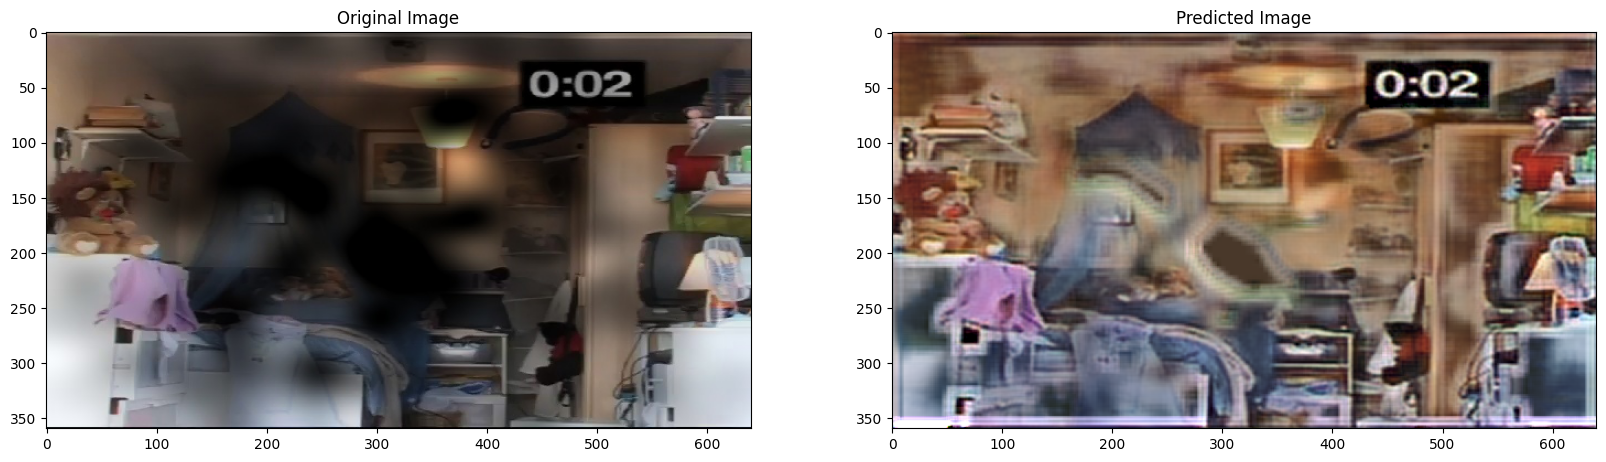

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt

image_size = (360, 640)
# test_image_path = '/home/aryan/sih23/Dataset/MASK_CUSTOM/38342.jpg'  
test_image_path = 'Dataset/Black_dataset/hazy_39006.jpg'

# Load and preprocess the test image
test_image = load_img(test_image_path, target_size=image_size)
test_image = img_to_array(test_image)
test_image = test_image / 255.0  

# Reshape the test image to match the model's input shape
test_image = np.expand_dims(test_image, axis=0)

# Use the model to make predictions
predicted_image = model.predict(test_image, verbose=0)
predicted_image = np.clip(predicted_image, 0.0, 1.0)


plt.figure(figsize=(20, 7))
original_image = load_img(test_image_path, target_size=image_size)

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image)


predicted_image = predicted_image[0]  
plt.subplot(1, 2, 2)
plt.title('Predicted Image')
plt.imshow(predicted_image)

plt.show()


Video Inference



In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm
from tensorflow.keras.models import load_model

# Paths
input_video_path = 'Video/Experience-a-real-house-fire-thr.mp4'
output_folder = 'Video/Out_Frames/'
output_video_path = 'Video/output2.mp4'  # Path to the output video file
os.makedirs(output_folder, exist_ok=True)


# Constants
img_shape = (640, 360)

# Open the video file
cap = cv2.VideoCapture(input_video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out = cv2.VideoWriter(output_video_path, fourcc, fps, img_shape)

# Initialize a frame counter
frame_counter = 0

# Loop through the video frames
for i in tqdm(range(frame_count)):
    ret, frame = cap.read()
    if not ret:
        break

    # Only process frames when the frame counter is even (skip alternate frames)
    if frame_counter % 2 == 0:
        # Preprocess the frame
        frame = cv2.resize(frame, img_shape)
        frame = frame / 255.0

        # Predict using the model
        predicted_frame = model.predict(np.expand_dims(frame, axis=0), verbose=0)
        predicted_frame = np.clip(predicted_frame, 0.0, 1.0)
        predicted_frame = (predicted_frame[0] * 255).astype(np.uint8)

        # Write the predicted frame to the output video
        out.write(predicted_frame)
        out.write(predicted_frame)

    # Increment the frame counter
    frame_counter += 1

# Release the video capture object and the VideoWriter
cap.release()
out.release()

print(f"Processed {frame_count} frames and saved as '{output_video_path}'")

Live Video Inference

In [ ]:
import cv2
import numpy as np
import tensorflow
from keras.models import load_model

# Constants
img_shape = (360, 640)

# Open the camera
cap = cv2.VideoCapture(1)

while True:
    ret, frame = cap.read()

    frame = cv2.resize(frame, img_shape)
    frame = frame / 255.0

    predicted_frame = model.predict(np.expand_dims(frame, axis=0))
    predicted_frame = np.clip(predicted_frame, 0.0, 1.0)
    predicted_frame = (predicted_frame[0] * 255).astype(np.uint8)

    cv2.imshow('Original Frame', frame)
    cv2.imshow('Predicted Frame', predicted_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()